# Beginning of Project

In [39]:
import os
import zipfile
import pandas as pd
import pyarrow as pa
import pyarrow.csv
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
non_state_codes = [
    "DC", "PR", "AE", "VI", "AP", "GU", 
    "MP", "AA", "AS", "EN", "GE", "QC", 
    "XX", "NO", "AB", "ZZ"
]
state_codes = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [18]:
# Open the merged ZIP file and extract the CSV
output_file = "P00000001-ALL.zip"
with zipfile.ZipFile(output_file, "r") as zip_ref:
    csv_filename = "P00000001-ALL.csv"
    csv_data = zip_ref.read(csv_filename)#.decode("utf-8")  # Read CSV as text

print(f"Extracted CSV: {csv_filename}")
cf_df = pa.csv.read_csv(pa.BufferReader(csv_data)).to_pandas()
#cf_df.iloc[:5]

Extracted CSV: P00000001-ALL.csv


In [19]:
# clean dataset 
# remove non state codes
cf_df = cf_df.loc[cf_df["contbr_st"].isin(state_codes)]
# change type of contb_receipt_dt column
cf_df["contb_receipt_dt"] = pd.to_datetime(cf_df["contb_receipt_dt"], format="%d-%b-%y")

In [20]:
x = dict(cf_df["contbr_st"].value_counts())
x = sorted(x.items(), key=lambda x: x[1], reverse=True)
x

[('CA', 2315984),
 ('TX', 1326243),
 ('FL', 1291672),
 ('NY', 900787),
 ('WA', 575317),
 ('PA', 565513),
 ('IL', 510471),
 ('VA', 488029),
 ('NC', 477878),
 ('AZ', 464248),
 ('GA', 451714),
 ('OH', 436920),
 ('MA', 435617),
 ('MI', 428944),
 ('NJ', 420016),
 ('CO', 383827),
 ('MD', 345356),
 ('OR', 324955),
 ('TN', 307066),
 ('MN', 284656),
 ('SC', 264966),
 ('MO', 252251),
 ('IN', 239801),
 ('WI', 228696),
 ('CT', 190887),
 ('AL', 179589),
 ('NV', 179087),
 ('OK', 168439),
 ('LA', 157091),
 ('UT', 147325),
 ('NM', 133366),
 ('KY', 126308),
 ('KS', 122317),
 ('IA', 113651),
 ('AR', 111944),
 ('ID', 111347),
 ('NH', 105191),
 ('ME', 90648),
 ('MS', 86034),
 ('NE', 73413),
 ('MT', 71174),
 ('HI', 68262),
 ('DE', 61585),
 ('WV', 55229),
 ('AK', 53548),
 ('RI', 48420),
 ('VT', 46883),
 ('WY', 38456),
 ('SD', 36873),
 ('ND', 29511)]

In [21]:
new = cf_df.set_index(["contbr_st","contbr_zip"])
new.head()

cmte_id    cand_id            cand_nm  \
contbr_st contbr_zip                                            
AK        99567       C00540302  P40012155  Scott, Timothy E.   
          99518       C00540302  P40012155  Scott, Timothy E.   
          99611       C00540302  P40012155  Scott, Timothy E.   
          99611       C00540302  P40012155  Scott, Timothy E.   
          99611       C00540302  P40012155  Scott, Timothy E.   

                      contb_receipt_amt contb_receipt_dt election_tp  
contbr_st contbr_zip                                                  
AK        99567                   100.0       2023-06-28       P2024  
          99518                    30.0       2023-06-25       P2024  
          99611                    50.0       2023-04-04       P2028  
          99611                   -50.0       2023-04-12       P2028  
          99611                    50.0       2023-04-12       P2024

In [22]:
new_summed = pd.DataFrame(new.groupby(level=["contbr_st", "contbr_zip"])["contb_receipt_amt"].sum())
new_summed.head()

contb_receipt_amt
contbr_st contbr_zip                   
AK        00000                  297.00
          01455                  260.04
          03281                 1206.50
          06066                  -25.00
          11111                  278.30

In [23]:
elec_df = pd.read_excel("2024presgeresults.xlsx")

# clean dataset
elec_df.fillna(0, inplace=True)

elec_df.head()

,STATE,ELECTORAL VOTES,ELECTORAL VOTE: TRUMP (R),ELECTORAL VOTE: HARRIS (D),AYYADURAI,BOWMAN,DE LA CRUZ,DUNCAN,EBKE,EVERYLOVE,...,STODDEN,SUPREME,TERRY,TRUMP,WELLS,WEST,WOOD,NONE OF THESE CANDIDATES,WRITE-INS (SCATTERED),TOTAL VOTES
0,AL,9,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1462616.0,0.0,0.0,0.0,0.0,8738.0,2265090.0
1,AK,3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,812.0,184458.0,0.0,1127.0,0.0,0.0,0.0,338177.0
2,AZ,11,11.0,0.0,77.0,0.0,689.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1770242.0,0.0,0.0,0.0,0.0,23.0,3390161.0
3,AR,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,759241.0,0.0,0.0,1144.0,0.0,0.0,1182676.0
4,CA,54,0.0,54.0,0.0,0.0,72539.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6081697.0,0.0,0.0,0.0,0.0,0.0,15865475.0


In [24]:
elec_df.columns

Index(['STATE', 'ELECTORAL VOTES', 'ELECTORAL VOTE: TRUMP (R)',
       'ELECTORAL VOTE: HARRIS (D)', 'AYYADURAI', 'BOWMAN', 'DE LA CRUZ',
       'DUNCAN', 'EBKE', 'EVERYLOVE', 'FRUIT', 'GARRITY', 'HARRIS', 'HUBER',
       'KENNEDY', 'KISHORE', 'OLIVER', 'PRESTON', 'SKOUSEN', 'SONSKI', 'STEIN',
       'STODDEN', 'SUPREME', 'TERRY', 'TRUMP', 'WELLS', 'WEST', 'WOOD',
       'NONE OF THESE CANDIDATES', 'WRITE-INS (SCATTERED)', 'TOTAL VOTES'],
      dtype='object')

In [25]:
# filter cf_df to only presidential candidates
elec_df.drop(columns=['AYYADURAI', 'BOWMAN', 'DE LA CRUZ', 'DUNCAN', 'EBKE', 'EVERYLOVE', 'FRUIT', 'GARRITY', 'HUBER', 'KENNEDY', 'KISHORE', 'OLIVER', 'PRESTON', 'SKOUSEN', 'SONSKI', 'STEIN', 'STODDEN', 'SUPREME', 'TERRY', 'WELLS', 'WEST', 'WOOD', 'NONE OF THESE CANDIDATES', 'WRITE-INS (SCATTERED)'], inplace=True)
elec_df.head()

,STATE,ELECTORAL VOTES,ELECTORAL VOTE: TRUMP (R),ELECTORAL VOTE: HARRIS (D),HARRIS,TRUMP,TOTAL VOTES
0,AL,9,9.0,0.0,772412.0,1462616.0,2265090.0
1,AK,3,3.0,0.0,140026.0,184458.0,338177.0
2,AZ,11,11.0,0.0,1582860.0,1770242.0,3390161.0
3,AR,6,6.0,0.0,396905.0,759241.0,1182676.0
4,CA,54,0.0,54.0,9276179.0,6081697.0,15865475.0


In [26]:
# grab total vote values for each candidate
trump_total_votes = elec_df.iloc[51]['TRUMP']
harris_total_votes = elec_df.iloc[51]['HARRIS']

In [27]:
trump_total_votes

77302580.0

In [28]:
harris_total_votes

75017613.0

In [37]:
state_contribs = new_summed.groupby("contbr_st")["contb_receipt_amt"].sum().reset_index()
merged_df = pd.merge(state_contribs, elec_df, left_on="contbr_st", right_on="STATE", how="inner")
merged_df.drop('STATE', axis=1)

,contbr_st,contb_receipt_amt,ELECTORAL VOTES,ELECTORAL VOTE: TRUMP (R),ELECTORAL VOTE: HARRIS (D),HARRIS,TRUMP,TOTAL VOTES
0,AK,3.724202e+06,3,3.0,0.0,140026.0,184458.0,338177.0
1,AL,1.086932e+07,9,9.0,0.0,772412.0,1462616.0,2265090.0
2,AR,6.836637e+06,6,6.0,0.0,396905.0,759241.0,1182676.0
3,AZ,2.919796e+07,11,11.0,0.0,1582860.0,1770242.0,3390161.0
4,CA,2.361143e+08,54,0.0,54.0,9276179.0,6081697.0,15865475.0
5,CO,3.352707e+07,10,0.0,10.0,1728159.0,1377441.0,3192745.0
6,CT,2.034150e+07,7,0.0,7.0,992053.0,736918.0,1759010.0
7,DE,5.140186e+06,3,0.0,3.0,289758.0,214351.0,512912.0
8,FL,1.031465e+08,30,30.0,0.0,4683038.0,6110125.0,10893752.0
9,GA,3.283596e+07,16,16.0,0.0,2548017.0,2663117.0,5250905.0


In [38]:
merged_df.head()

,contbr_st,contb_receipt_amt,STATE,ELECTORAL VOTES,ELECTORAL VOTE: TRUMP (R),ELECTORAL VOTE: HARRIS (D),HARRIS,TRUMP,TOTAL VOTES
0,AK,3.724202e+06,AK,3,3.0,0.0,140026.0,184458.0,338177.0
1,AL,1.086932e+07,AL,9,9.0,0.0,772412.0,1462616.0,2265090.0
2,AR,6.836637e+06,AR,6,6.0,0.0,396905.0,759241.0,1182676.0
3,AZ,2.919796e+07,AZ,11,11.0,0.0,1582860.0,1770242.0,3390161.0
4,CA,2.361143e+08,CA,54,0.0,54.0,9276179.0,6081697.0,15865475.0


/var/folders/wc/qr2wqx1n4_l9pzxfdkffs5r00000gn/T/ipykernel_62469/379988839.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df, x="contbr_st", y="contb_receipt_amt", palette="viridis")


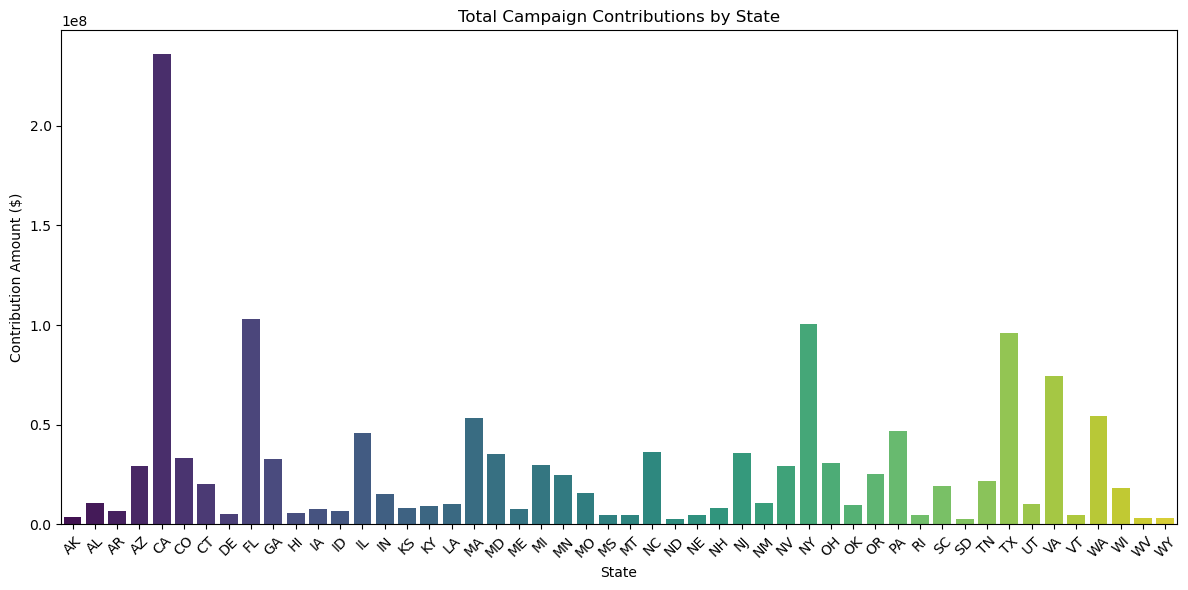

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(data=merged_df, x="contbr_st", y="contb_receipt_amt", palette="viridis")

plt.title("Total Campaign Contributions by State")
plt.xlabel("State")
plt.ylabel("Contribution Amount ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()